# 分散分析

分散分析は平均値の差を検定する手法。<br>
平均値の差の検定はt検定でも可能だが、水準（カテゴリ型変数のこと）を3つ以上持つデータを対象にする場合は分散分析を用いる。

分散分析は、母集団が正規分布に従うデータに対してのみ適用可能。<br>
また、水準間で分散の値が異ならないという条件も満たしていなければならない。


### 分散分析の考え方

- 帰無仮説：水準間で平均値に差はない
- 対立仮説：水準間で平均値に差がある

分散分析では、データの変動を「効果」と「誤差」に分離し、その上で**F比**という統計量を計算する。

```
F比 = 効果の分散の大きさ ÷ 誤差の分散の大きさ
```

- 効果：水準の違いがもたらす変動（天気の違いによる売上の差）
- 誤差：効果で説明することのできなかった変動（同じ天気の日でも売上は異なる）

影響の大きさを分散を用いて定量化し、その分散の比を統計量として検定を行う。<br>
F比が大きければ、誤差に比べて効果の影響が大きいと判断される。

母集団分布が等分散正規分布である時のF比の標本分布はF分布と呼ばれる。<br>
F分布の累積分布関数を用いることでp値を計算し、p値が 0.05 以下になった場合に帰無仮説を棄却する。

----

In [8]:
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import statsmodels.formula.api as smf
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
# 分析対象となる天気とビールの売上の関係データ
# 天気が晴れ・雨・曇りの3つの場合において、ビールの売上が有意に異なるかどうかを分析する
weather = ['cloudy', 'cloudy', 'rainy', 'rainy', 'sunny', 'sunny']
beer = [6, 8, 2, 4, 10, 12]

weather_beer = pd.DataFrame(
    {'weather': weather, 'beer': beer}
)
weather_beer

,beer,weather
0,6,cloudy
1,8,cloudy
2,2,rainy
3,4,rainy
4,10,sunny
5,12,sunny


In [5]:
# 水準間での分散の値は異ならない
weather_beer.groupby('weather').var(ddof=1)

,beer
weather,
cloudy,2
rainy,2
sunny,2


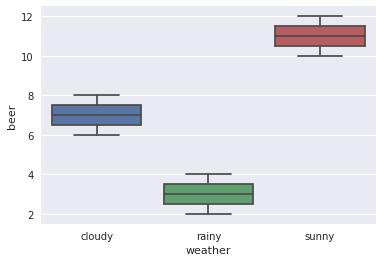

In [6]:
# サンプルサイズが小さいので箱ひげ図で図示
sns.boxplot(x='weather', y='beer', data=weather_beer)

# 各水準間の中央値の差が効果の大きさ（群間変動）
# 各水準内の最大値・最小値の幅が誤差の大きさ（群内変動）

In [4]:
# 天気ごとの売上の平均値
weather_beer.groupby('weather').mean()

,beer
weather,
cloudy,7
rainy,3
sunny,11


### ■ statsmodels による一元配置分散分析

----

In [1]:
anova_model = smf.ols(formula='beer ~ weather', data=weather_beer).fit()

# 分散分析表の出力（Type II ANOVA）
sm.stats.anova_lm(anova_model, typ=2)

NameError: name 'smf' is not defined

In [10]:
# モデルの係数
anova_model.params

Intercept           7.0
weather[T.rainy]   -4.0
weather[T.sunny]    4.0
dtype: float64

----
#### モデルの係数の解釈

カテゴリ型変数なので（晴れ・雨・曇り）の説明変数に対して、0 か 1 が対応する。<br>
モデルの式としては以下のようになる。

ビールの売上 ~ *N*(${\beta}_0$ + ${\beta}_1$ × 雨 + ${\beta}_2$ × 晴, ${\sigma}^2$)

雨でもなく、晴れでもないときは ${\beta}_0$ のみが残るため、切片が曇りの影響を表すパラメータとして解釈される。

----

### ■ 手作業による一元配置分散分析

----

In [5]:
# 天気の平均値が分かっているので、天気による影響だけを考えた場合の売上は以下のようになる
# 例）天気が曇りになることによって、売上は 7 万円になると期待できる
effect = [7, 7, 3, 3, 11, 11]

In [9]:
# ①この effect のばらつきの大きさを求めることで、群間変動を計算できる
mu_effect = sp.mean(effect)
squares_model = sp.sum((effect - mu_effect) ** 2)
squares_model

64.0

In [10]:
# 誤差は、元データから効果を引くことによって算出される
# ②これから群内変動を計算できる
resid = weather_beer['beer'] - effect
squares_resid = sp.sum(resid ** 2)
squares_resid

6

In [11]:
# ③群間変動の自由度（水準の種類数 - 1）
df_model = 2

# ④群内変動の自由度（サンプルサイズ - 水準の種類数）
df_resid = 3

In [12]:
# 群間の分散（① / ③）
variance_model = squares_model / df_model
variance_model

32.0

In [13]:
# 群内の分散（② / ④）
variance_resid = squares_resid / df_resid
variance_resid

2.0

In [15]:
# F比
f_ratio = variance_model / variance_resid
f_ratio

16.0

In [16]:
# p値はF分布の累積分布関数から求める
1 - stats.f.cdf(x=f_ratio, dfn=df_model, dfd=df_resid)

# p-value < 0.05 となったので、天気によって売上は有意に変化すると判断できる

0.02509457330439091